In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

In [ ]:
def generate_random_dataset(elements, groups):
  """
  Se generan numeros aleatorios entre 0 y elements para crear un data set diferenciando entre groups grupos.
  """
  random_numbers = np.sort(np.random.randint(0, elements, groups - 1))
  group_sizes = [random_numbers[0]] + [random_numbers[i + 1] - random_numbers[i] for i in range(groups - 2)] + [elements - random_numbers[-1]]

  dataset = []
  for group_index, group_size in enumerate(group_sizes):
      dataset.extend([group_index] * group_size)

  np.random.shuffle(dataset)
  
  return dataset

In [ ]:
def generate_list_datasets(numdatasets, elements, groups):
  """
  Se generan numdatasets para analizar los resultados con varios datasets con distintas cantidades de los grupos.
  """
  listdatasets = []
  for i in range(numdatasets):
    listdatasets.append(generate_random_dataset(elements, groups))
  return listdatasets

In [ ]:
def generate_random_probabilities(num_probabilities):
  """
  Genera num_probabilities aleatorias para cada pelicula: Son 3, primera si gusta mucho, segunda si gusta poco y
  tercera si no gusta.
  """
  random_probs = np.random.rand(num_probabilities - 1)
  random_probs = np.sort(np.concatenate(([0], random_probs, [1])))
  return np.diff(random_probs)

In [ ]:
def generate_movie_probabilities(num_movies, num_groups):
  """
  Obtiene las probabilidades de cada grupo (num_groups) para cada pelicula (num_movies) 
  """
  probabilities = {}
  num_probabilities = 3
  for group in range(num_groups):
      group_probabilities = []
      for movie in range(num_movies):
          movie_probabilities = generate_random_probabilities(num_probabilities)
          group_probabilities.append(movie_probabilities)
      probabilities[group] = group_probabilities

  
  return probabilities

In [ ]:
class UCB1:
  """
  Implementación del algoritmo UCB1.
  """
  def __init__(self, num_arms):
      self.counts = np.zeros(num_arms)  # selecciones de cada brazo
      self.values = np.zeros(num_arms)  # media brazo

  def select_arm(self):
      n_total = sum(self.counts)
      if n_total == 0:
          return np.random.randint(len(self.counts)) # si no se había seleccionado ningún brazo
      
      term = 1e-5
      explore_rate = 2 * np.log(n_total) / (self.counts + term) # 2logT/n
      ucb_values = self.values + np.sqrt(explore_rate) # se calcula ucb y se elige aquel con mayor ucb
      return np.argmax(ucb_values)

  def update(self, arm, reward):
      self.counts[arm] += 1
      self.values[arm] = ((self.counts[arm] - 1) * self.values[arm] + reward) / self.counts[arm]


In [ ]:
def simulate_contextual_bandits(T, num_datasets, num_movies, num_groups):
    datasets = generate_list_datasets(num_datasets, T, num_groups)
    dsize = len(datasets)
    i = 0
    total_reward = np.zeros(dsize)
    total_loss = np.zeros(dsize)
    total_rewardUCB = np.zeros(dsize)
    total_lossUCB = np.zeros(dsize)
    K = 5
    movie_probabilities = generate_movie_probabilities(num_movies, num_groups)

    for data in datasets:
      def reward_function(context, arm):
          probs = movie_probabilities[context][arm]
          return np.random.choice([5, 3, 0], p=probs)
      instances = [UCB1(K) for _ in range(num_groups)]
      instanceUCB = UCB1(K)

      for t in range(T):
        context = data[t]

        alg = instances[context]
        arm = alg.select_arm()
        contextualreward = (reward_function(context, arm)) / 5
        alg.update(arm, contextualreward)
        total_reward[i] += contextualreward
        total_loss[i] += (1- contextualreward)

        alg2 = instanceUCB
        arm2 = alg2.select_arm()
        reward = (reward_function(context, arm2)) / 5
        alg2.update(arm2, reward)        
        total_rewardUCB[i] += reward
        total_lossUCB[i] += (1- reward)
      i = i + 1

    return total_reward, total_loss, total_rewardUCB, total_lossUCB

In [ ]:
def plot_mean_rewards_losses_and_difference(all_total_reward, all_total_loss, all_total_rewardUCB, all_total_lossUCB, num_groups_values):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(num_groups_values, all_total_reward, label="Recompensas contextual bandit", color="blue", linewidth=2, linestyle="-", marker="o")
    plt.plot(num_groups_values, all_total_rewardUCB, label="Recompensas UCB1", color="red", linewidth=2, linestyle="--", marker="s")
    plt.xlabel("Número de contextos")
    plt.ylabel("Recompensa media")
    plt.legend(loc="upper left")
    plt.title("Recompensas medias por grupos")
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.plot(num_groups_values, all_total_loss, label="Pérdidas contextual bandit", color="green", linewidth=2, linestyle="-", marker="o")
    plt.plot(num_groups_values, all_total_lossUCB, label="Pérdidas UCB1", color="purple", linewidth=2, linestyle="--", marker="s")
    plt.xlabel("Número de contextos")
    plt.ylabel("Pérdida media")
    plt.legend(loc="upper left")
    plt.title("Pérdidas medias por grupos")
    plt.grid()

    plt.subplot(1, 3, 3)
    loss_difference = np.array(all_total_loss) - np.array(all_total_lossUCB)
    plt.plot(num_groups_values, loss_difference, label="Diferencia de pérdidas", color="blue", linewidth=2, linestyle="-", marker="o")
    plt.xlabel("Número de contextos")
    plt.ylabel("Diferencia de pérdida media")
    plt.legend(loc="upper left")
    plt.title("Diferencia de pérdidas Contextual - UCB")
    plt.grid()

    plt.tight_layout()
    plt.show()

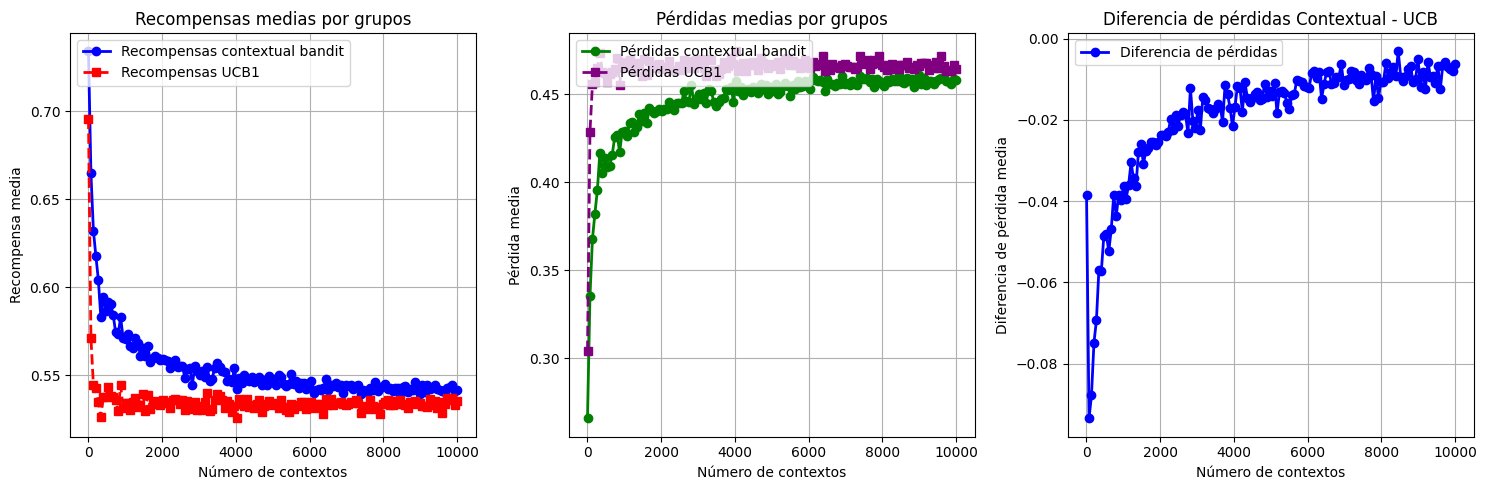

In [ ]:

T = 10000
num_datasets = 5
num_movies = 5
num_iterations = 150

num_groups_values = np.linspace(4, T, num_iterations).astype(int)

all_total_reward = np.zeros(num_iterations)
all_total_loss = np.zeros(num_iterations)
all_total_rewardUCB = np.zeros(num_iterations)
all_total_lossUCB = np.zeros(num_iterations)
i = 0
for num_groups in num_groups_values:
    total_reward, total_loss, total_rewardUCB, total_lossUCB = simulate_contextual_bandits(T, num_datasets, num_movies, num_groups)
    all_total_reward[i] = np.mean(total_reward)/T
    all_total_loss[i] = np.mean(total_loss)/T
    all_total_rewardUCB[i] = np.mean(total_rewardUCB)/T
    all_total_lossUCB[i] = np.mean(total_lossUCB)/T
    i+=1

plot_mean_rewards_losses_and_difference(all_total_reward, all_total_loss, all_total_rewardUCB, all_total_lossUCB, num_groups_values)



